In [2]:
## Keras configuration

# Set KERAS backend to Theano
import os
os.environ['KERAS_BACKEND']='theano'

# Load Keras
import keras

# Load the libraries
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD

Using Theano backend.


In [3]:
import pandas as pd
from functools import reduce

In [4]:
# Load Data into array

nodes = []
for x in range(0, 5):
    nodes.append(pd.read_csv('https://raw.githubusercontent.com/Amitangshu/Irradiance_sensing/master/All_Data_For_EPIC_Roof/MDA300n' + str(x+150) +'.dat',
                     error_bad_lines=False, header=1))
    print("Loaded file MDA300n"+str(x+150)+".dat")

Loaded file MDA300n150.dat
Loaded file MDA300n151.dat
Loaded file MDA300n152.dat


b'Skipping line 47729: expected 7 fields, saw 13\n'


Loaded file MDA300n153.dat
Loaded file MDA300n154.dat


In [5]:
# Split TimeStamp into Date and Time columns and 

numNodes = len(nodes)
for y in range(numNodes):
    nodes[y][['DATE','TIME']] = nodes[y].TMSTAMP.str.split(expand=True)

In [6]:
for w in range(numNodes):
    nodes[w] = nodes[w].drop('TMSTAMP', 1)
    nodes[w] = nodes[w].drop('RECNBR', 1)
    nodes[w] = nodes[w].drop('PARENT', 1)
    nodes[w] = nodes[w].drop('SOLAROCV', 1)
    nodes[w] = nodes[w].drop('VBATT', 1)
    nodes[w] = nodes[w].drop('TEMP', 1)
    nodes[w] = nodes[w].drop('DATE', 1)

In [7]:
print(nodes[0].columns)

Index(['IRRADIANCE', 'TIME'], dtype='object')


In [8]:
# Explore data to see the distribution of irradiance values

count = []
for z in range(numNodes):
    count.append(nodes[z].IRRADIANCE.value_counts())

In [9]:
count[0].index

Float64Index([   2.92,    5.83,    8.75,   11.67,   20.42,   14.58,    35.0,
                 17.5,   55.41,   26.25,
              ...
              3094.41, 7151.27, 6602.96, 6675.88, 7256.26, 4742.24, 8026.22,
              1388.26, 3505.64, 2397.37],
             dtype='float64', length=2003)

In [10]:
# Select the 10 class values
class_values = [2.92, 8.75, 3.07, 2.81, 3.17, 8.44, 2.74, 2.98, 3.14, 3.52]

In [11]:
# Subset data by the selected class values

subset = []
for a in range(numNodes):
    subset.append(nodes[a][nodes[a].IRRADIANCE.isin(class_values)])

In [12]:
print(nodes[0].columns)

Index(['IRRADIANCE', 'TIME'], dtype='object')


In [13]:
# Merge the subsets

data = reduce(lambda  left,right: pd.merge(left,right,on=['IRRADIANCE','TIME'],how='outer'), nodes)

In [14]:
data.head()
print(data.size)

569638


In [15]:
# Transform Time column into numeric (hours)
data.TIME = pd.to_timedelta(data.TIME)
data.TIME = data.TIME.dt.seconds/3600

In [16]:
# Creating labels:

# Convert the labels into categorical classification
# Class values: {2.92, 8.75, 3.07, 2.81} correspond to {0, 1, 2, 3}
data.loc[data.IRRADIANCE==2.92, 'IRRADIANCE'] = 0
data.loc[data.IRRADIANCE==8.75, 'IRRADIANCE'] = 1
data.loc[data.IRRADIANCE==3.07, 'IRRADIANCE'] = 2
data.loc[data.IRRADIANCE==2.81, 'IRRADIANCE'] = 3
data.loc[data.IRRADIANCE==3.17, 'IRRADIANCE'] = 4
data.loc[data.IRRADIANCE==8.44, 'IRRADIANCE'] = 5
data.loc[data.IRRADIANCE==2.74, 'IRRADIANCE'] = 6
data.loc[data.IRRADIANCE==2.98, 'IRRADIANCE'] = 7
data.loc[data.IRRADIANCE==3.14, 'IRRADIANCE'] = 8
data.loc[data.IRRADIANCE==3.52, 'IRRADIANCE'] = 9

In [17]:
data.head()

,IRRADIANCE,TIME
0,40.83,18.887500
1,40.83,18.920000
2,17.50,19.066944
3,17.50,19.083056
4,14.58,19.099167


In [64]:
# Split data into three parts: training(40%), testing(30%), validation(30%)
# Use scikit-learn

import sklearn
from sklearn.model_selection import train_test_split

Train_Set, Test_Set = train_test_split(data, train_size=0.4, test_size=0.3, shuffle=True)

In [65]:
# Extract the feature columns: IRRADIANCE, TIME

#X_train = np.array(Train_Set[['IRRADIANCE', 'TIME']]).astype('float64')
#X_test = np.array(Test_Set[['IRRADIANCE','TIME']]).astype('float64')

X_train = np.array(Train_Set[['IRRADIANCE','TIME']]).astype('float64')
X_test = np.array(Test_Set[['IRRADIANCE','TIME']]).astype('float64')

# Input Shape
shape_ord = (X_train[0].shape)

In [66]:
# Extract the label column: IRRADIANCE

# Cast the label as integer
Y_train = np.array(Train_Set[['IRRADIANCE']]).astype('int')
Y_test = np.array(Test_Set[['IRRADIANCE']]).astype('int')

from keras.utils import to_categorical
# Convert the labels into categorical form
Y_train = to_categorical(Y_train, num_classes=8750)
Y_test = to_categorical(Y_test, num_classes=8750)

In [67]:
shape_ord

(2,)

### Training the final model

In [44]:
# Initialize the parameters
# Number of epochs
nb_epochs = 2
# Batch size
batch_size = 128
# Vanilla SGD
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

In [68]:
model = Sequential()

model.add(Dense(10, activation='relu', input_dim=2))
model.add(Dropout(1.0))
model.add(Dense(10, activation='relu'))
model.add(Dropout(1.0))
model.add(Dense(8750, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 10)                30        
_________________________________________________________________
dropout_9 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_10 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 8750)              96250     
Total params: 96,390
Trainable params: 96,390
Non-trainable params: 0
_________________________________________________________________


In [69]:
hist = model.fit(X_train, Y_train, batch_size=batch_size,validation_split=0.33, 
                 epochs=nb_epochs, verbose=1, 
                 validation_data=(X_test, Y_test))

Train on 113927 samples, validate on 85446 samples
Epoch 1/2
113927/113927 [==============================] - 104s 910us/step - loss: 5.1671 - accuracy: 0.2271 - val_loss: 4.2808 - val_accuracy: 0.2303
Epoch 2/2
113927/113927 [==============================] - 120s 1ms/step - loss: 4.1623 - accuracy: 0.2304 - val_loss: 4.0974 - val_accuracy: 0.2312


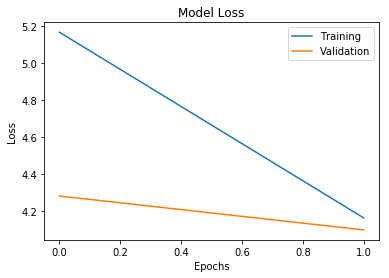

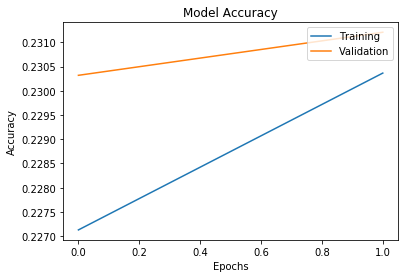

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [48]:
# Evaluating the model on the test data    
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Test Loss: 5.6280216123577675
Test Accuracy: 0.20160101354122162


Train on 113927 samples, validate on 85446 samples
Epoch 1/2
113927/113927 [==============================] - 214s 2ms/step - loss: 4.6884 - accuracy: 0.1784 - val_loss: 4.5858 - val_accuracy: 0.2016
Epoch 2/2
113927/113927 [==============================] - 222s 2ms/step - loss: 4.5814 - accuracy: 0.1847 - val_loss: 4.6030 - val_accuracy: 0.2016


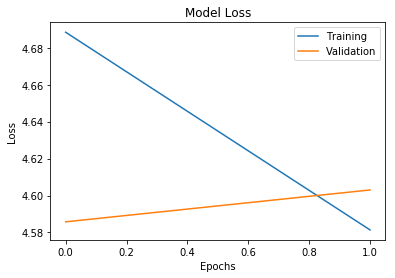

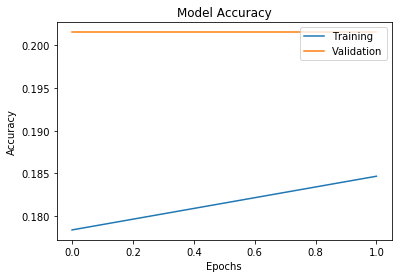

In [92]:
# Dropout Tests Batch=16
# Initialize the parameters
# Number of epochs
nb_epochs = 2
# Batch size
batch_size = 16
# Vanilla SGD
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

model = Sequential()

model.add(Dense(10, activation='relu', input_dim=2))
model.add(Dropout(1.0))
model.add(Dense(10, activation='relu'))
model.add(Dense(8750, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

hist = model.fit(X_train, Y_train, batch_size=batch_size,validation_split=0.33, 
                 epochs=nb_epochs, verbose=1, 
                 validation_data=(X_test, Y_test))

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [71]:
input = []
input.append(pd.read_csv('https://raw.githubusercontent.com/Amitangshu/Irradiance_sensing/master/All_Data_For_EPIC_Roof/MDA300n155.dat',
                     error_bad_lines=False, header=1))
print("Loaded file MDA300n155.dat")

Loaded file MDA300n155.dat


In [72]:
numRec = len(input)
for y in range(numRec):
    input[y][['DATE','TIME']] = input[y].TMSTAMP.str.split(expand=True)

In [73]:
for w in range(numRec):
    input[w] = input[w].drop('TMSTAMP', 1)
    input[w] = input[w].drop('RECNBR', 1)
    input[w] = input[w].drop('PARENT', 1)
    input[w] = input[w].drop('SOLAROCV', 1)
    input[w] = input[w].drop('VBATT', 1)
    input[w] = input[w].drop('TEMP', 1)
    input[w] = input[w].drop('DATE', 1)

In [74]:
print(input[0].columns)

Index(['IRRADIANCE', 'TIME'], dtype='object')


In [75]:
input = pd.DataFrame(input[0])

In [76]:
input.head()

,IRRADIANCE,TIME
0,8.44,19:18:21
1,8.44,19:20:17
2,8.44,19:22:13
3,5.63,19:23:12
4,5.63,19:25:08


In [77]:
input.TIME = pd.to_timedelta(input.TIME)
input.TIME = input.TIME.dt.seconds/3600

In [78]:
output = model.predict_classes(input)

In [85]:
for w in range(10):
    print("X=[%s, %.2f], Predicted=%.2s" % (input.loc[w].IRRADIANCE, input.loc[w].TIME, output[w]))

X=[8.44, 19.31], Predicted=0
X=[8.44, 19.34], Predicted=0
X=[8.44, 19.37], Predicted=0
X=[5.63, 19.39], Predicted=0
X=[5.63, 19.42], Predicted=0
X=[2.81, 19.57], Predicted=0
X=[2.81, 19.58], Predicted=0
X=[2.81, 19.60], Predicted=0
X=[2.81, 19.67], Predicted=0
X=[2.81, 19.68], Predicted=0


In [80]:
np.unique(output)

array([0, 3, 4])

In [89]:
oht

array([0, 0, 0, ..., 0, 0, 0])